This project analysis a dataset of patient clinical history to predict the probability of readmission for diabetes control. Data was collected from UCI ML repository (https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008)
citation: Clore, J., Cios, K., DeShazo, J., & Strack, B. (2014). Diabetes 130-US Hospitals for Years 1999-2008 [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5230J.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from numpy import mean
from numpy import std
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

import xgboost
from xgboost import XGBClassifier

In [2]:
#pip install ucimlrepo

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296) 
  
# data (as pandas dataframes) 
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features 
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets 
  
# metadata 
print(diabetes_130_us_hospitals_for_years_1999_2008.metadata) 
  
# variable information 
print(diabetes_130_us_hospitals_for_years_1999_2008.variables) 


{'uci_id': 296, 'name': 'Diabetes 130-US Hospitals for Years 1999-2008', 'repository_url': 'https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008', 'data_url': 'https://archive.ics.uci.edu/static/public/296/data.csv', 'abstract': 'The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the early readmission of the patient within 30 days of discharge.\nThe problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide pro

/Users/toluayangbayi/.pyenv/versions/3.12.3/envs/venv/lib/python3.12/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [3]:
## use this for first time. Data will be downloaded and saved in the current directory
## and read in directly from the file next time

#data_url = 'https://archive.ics.uci.edu/static/public/296/data.csv'
#df = pd.read_csv(data_url)

In [4]:
## save the data to a csv file
## df.to_csv('diabetes_130_us_hospitals_for_years_1999_2008.csv', index=False)

In [5]:
## read in the data from the csv file

df = pd.read_csv('diabetes_130_us_hospitals_for_years_1999_2008.csv')

/var/folders/tj/v617gh9d4l3gp_6tgf1tydqm0000gn/T/ipykernel_86076/2978513972.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('diabetes_130_us_hospitals_for_years_1999_2008.csv')


In [6]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [8]:
## are encounters unique?
df['encounter_id'].nunique()

101766

In [9]:
## how many unique patients?
df['patient_nbr'].nunique()

71518

With fewer unique patients than encounters, there is a high chance some patients were readmitted. 
Since the data was collected over a ten-year period, there is also a chance that patients might move around or that some information like age, weight, or height will change during this period.
The analysis should be conducted at patient-encounter level since each encounter is unique.

Exploratory analysis

In [10]:
## drop encounter number and patient number
df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

In [11]:
## get numeric columns

numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols

Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')

In [12]:
## get categorical columns

categorical_cols = df.select_dtypes(include=["object"]).columns
categorical_cols

Index(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

Univariate analysis

In [13]:
for c in categorical_cols:
    print(c)
    print(f"unique: {df[c].nunique()}")
    print(df[c].value_counts())
    print()

race
unique: 5
race
Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64

gender
unique: 3
gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64

age
unique: 10
age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64

weight
unique: 9
weight
[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: count, dtype: int64

payer_code
unique: 17
payer_code
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: count, dtype: int64


In [14]:
## Get a descriptive statistics of the numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
admission_type_id,101766.0,2.024006,1.445403,1.0,1.0,1.0,3.0,8.0
discharge_disposition_id,101766.0,3.715642,5.280166,1.0,1.0,1.0,4.0,28.0
admission_source_id,101766.0,5.754437,4.064081,1.0,1.0,7.0,7.0,25.0
time_in_hospital,101766.0,4.395987,2.985108,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,101766.0,43.095641,19.674362,1.0,31.0,44.0,57.0,132.0
num_procedures,101766.0,1.339730,1.705807,0.0,0.0,1.0,2.0,6.0
num_medications,101766.0,16.021844,8.127566,1.0,10.0,15.0,20.0,81.0
number_outpatient,101766.0,0.369357,1.267265,0.0,0.0,0.0,0.0,42.0
number_emergency,101766.0,0.197836,0.930472,0.0,0.0,0.0,0.0,76.0
number_inpatient,101766.0,0.635566,1.262863,0.0,0.0,0.0,1.0,21.0


mean hospital stay: approx. 4 days
mean number of lab tests: 4
mean number of procedures other than lab tests: 1
mean number of medications: 2
mean number of outpatient visits in the year preceding encounter: 4
mean ER visits in the year preceding encounter: 2
mean inpatient visits in the year preceding encounter: 6
mean number of diagnoses: 7

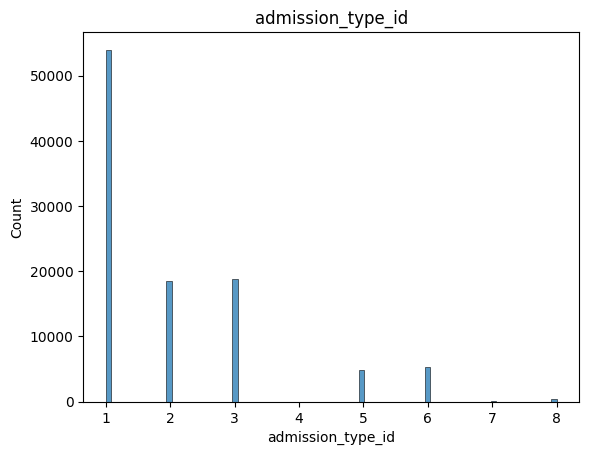

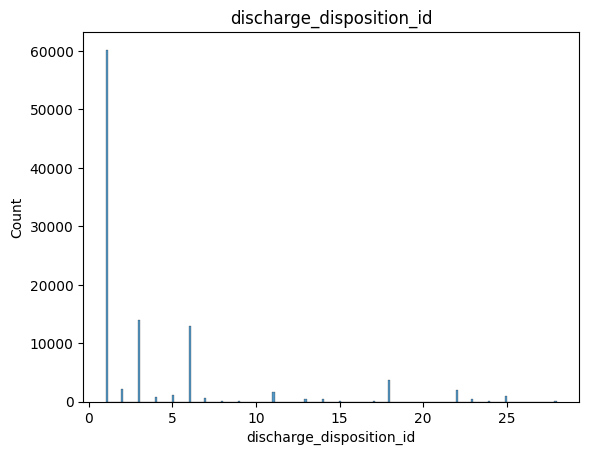

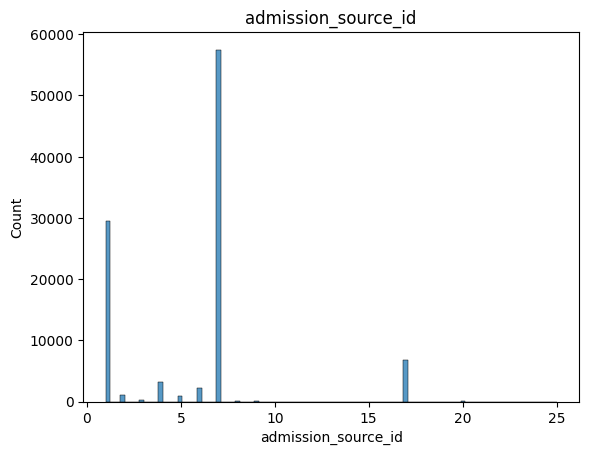

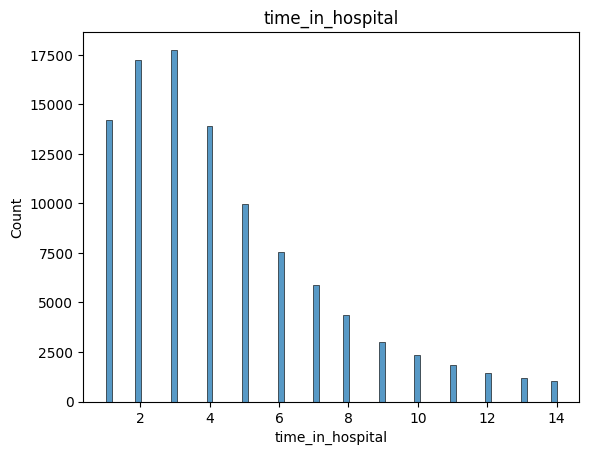

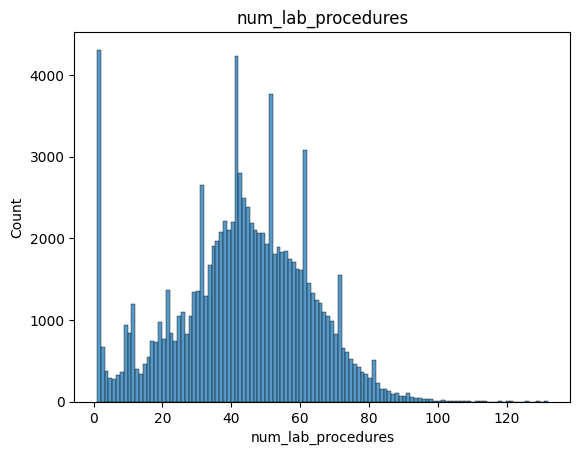

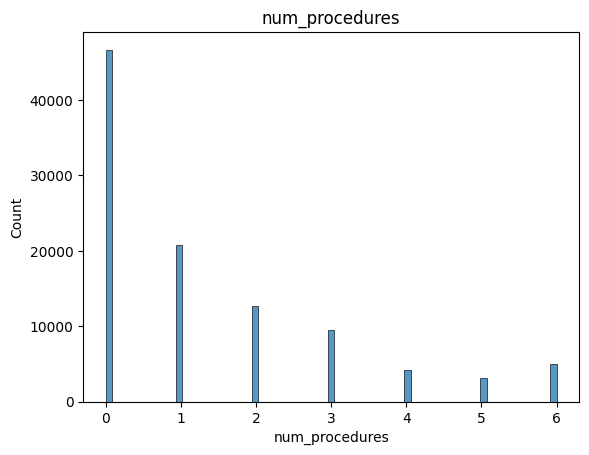

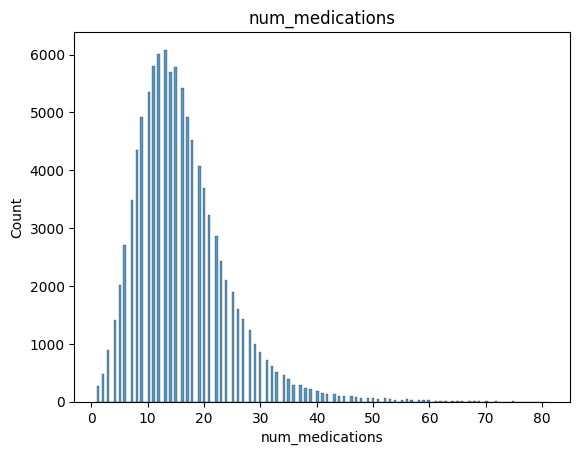

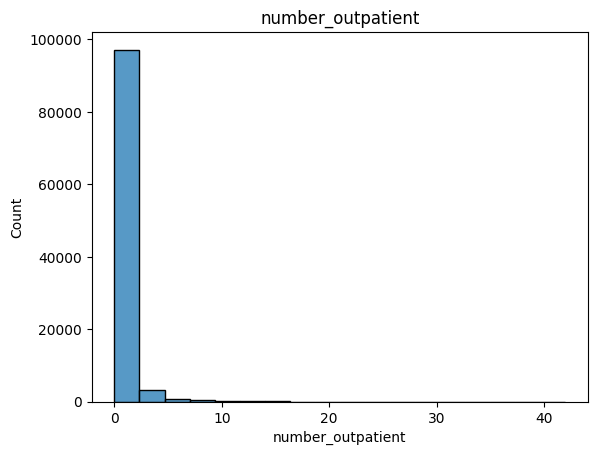

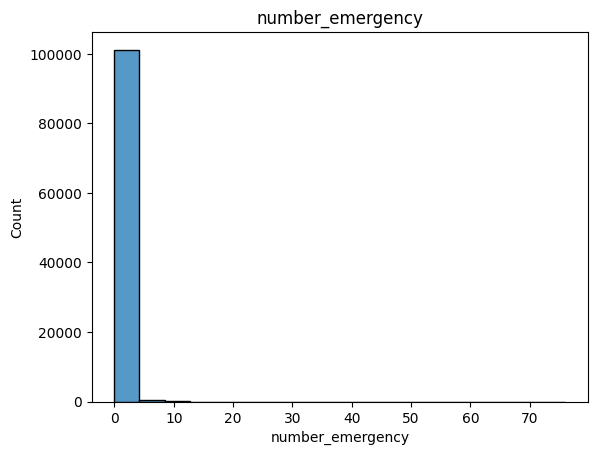

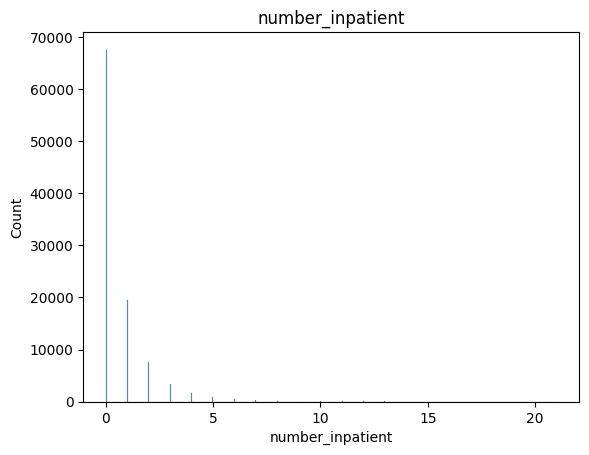

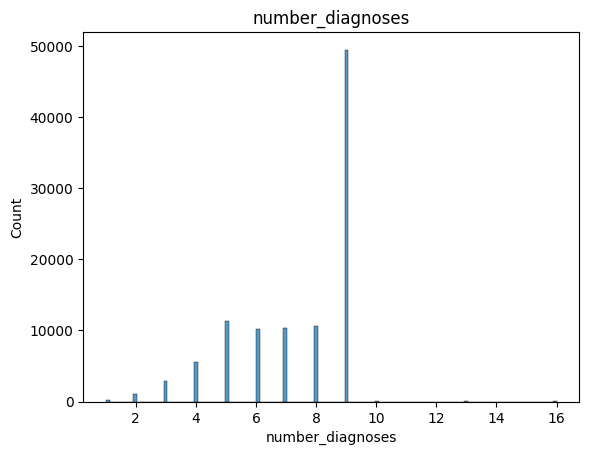

In [15]:
## univariate plots

for col in numeric_cols:
    sns.histplot(df[col])
    plt.title(col)
    plt.show()

Missing values

In [16]:
df.isnull().sum()/df.shape[0]

race                        0.022336
gender                      0.000000
age                         0.000000
weight                      0.968585
admission_type_id           0.000000
discharge_disposition_id    0.000000
admission_source_id         0.000000
time_in_hospital            0.000000
payer_code                  0.395574
medical_specialty           0.490822
num_lab_procedures          0.000000
num_procedures              0.000000
num_medications             0.000000
number_outpatient           0.000000
number_emergency            0.000000
number_inpatient            0.000000
diag_1                      0.000206
diag_2                      0.003518
diag_3                      0.013983
number_diagnoses            0.000000
max_glu_serum               0.947468
A1Cresult                   0.832773
metformin                   0.000000
repaglinide                 0.000000
nateglinide                 0.000000
chlorpropamide              0.000000
glimepiride                 0.000000
a

Feature selection and engineering

I will drop features based on the following rationale:
* features with more than 10% missing values
* categorical features with high cardinality because of the possibility of data explosion if one hot encoded.
* features that represent information about individual drugs or drug combination as this information is available in the features diabetesMed (whether on a diabetes medication), and change (whether a change was made to the patient's medications)

In [17]:
## dropping categorical columns with high cardinality and diabet
df = df.drop(["weight", "max_glu_serum", "A1Cresult", 'payer_code', 'medical_specialty',
       'diag_1', 'diag_2', 'diag_3', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone'], axis=1)

In [18]:
## recode the values for change and diabetesMed

df['change'] = df['change'].map({'Ch': 1, 'No': 0})
df['diabetesMed'] = df['diabetesMed'].map({'Yes': 1, 'No': 0})

In [19]:
df.isnull().sum()
## I will not drop or impute the rows with missing values for race
## rather, I will treat it as a separate category

race                        2273
gender                         0
age                            0
admission_type_id              0
discharge_disposition_id       0
admission_source_id            0
time_in_hospital               0
num_lab_procedures             0
num_procedures                 0
num_medications                0
number_outpatient              0
number_emergency               0
number_inpatient               0
number_diagnoses               0
change                         0
diabetesMed                    0
readmitted                     0
dtype: int64

In [20]:
## one hot encode some categorical columns: race, age, and gender

from sklearn.preprocessing import OneHotEncoder

## create OHE instance
encoder = OneHotEncoder(drop='first', handle_unknown='error')

## fit and transform the columns
encoder.fit(df[["race", "age", "gender"]])
encoded_data = encoder.transform(df[["race", "age", "gender"]]).toarray()

## create a dataframe from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(["race", "age", "gender"]))

## join encoded data with the original data
df = pd.concat([df, encoded_df], axis=1)

## drop the original columns
df.drop(columns=["race", "age", "gender"], inplace=True)


In [21]:
df.shape

(101766, 30)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   admission_type_id         101766 non-null  int64  
 1   discharge_disposition_id  101766 non-null  int64  
 2   admission_source_id       101766 non-null  int64  
 3   time_in_hospital          101766 non-null  int64  
 4   num_lab_procedures        101766 non-null  int64  
 5   num_procedures            101766 non-null  int64  
 6   num_medications           101766 non-null  int64  
 7   number_outpatient         101766 non-null  int64  
 8   number_emergency          101766 non-null  int64  
 9   number_inpatient          101766 non-null  int64  
 10  number_diagnoses          101766 non-null  int64  
 11  change                    101766 non-null  int64  
 12  diabetesMed               101766 non-null  int64  
 13  readmitted                101766 non-null  o

Modeling

In [23]:
## split the data into features and target
X = df.drop("readmitted", axis=1)
y = df["readmitted"]

In [24]:
print(X.shape, y.shape)

(101766, 29) (101766,)


Multinomial logistic regression

In [25]:
## define the multi-class logistic regression model

pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('model', LogisticRegression())  
   ])

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model and collect the scores
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.571 (0.003)
